# Detecting Modes on the Circle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances

from mergeTrees import *

### Creating a density on the circle

The following creates a particular density on the circle. We will illustrate the mode detection process on this example.

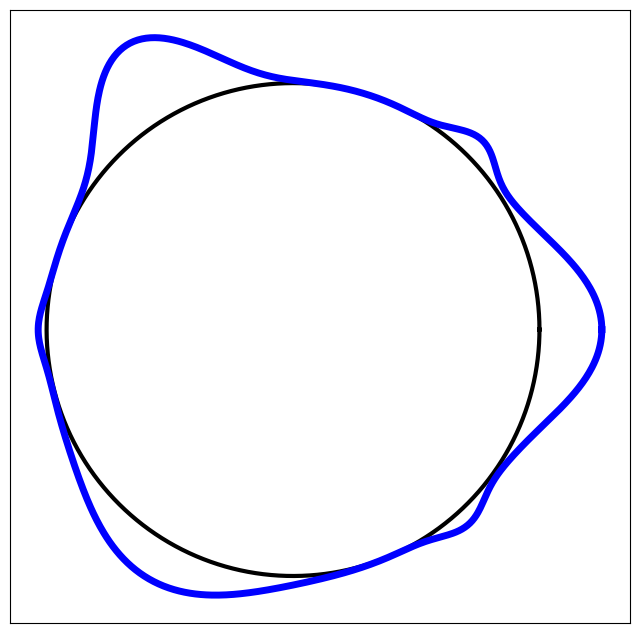

In [2]:
def smooth_circular_distribution(theta):
    """
    Define a smooth 4-modal probability density function over the circle.
    Args:
        theta: Angle in radians (array-like).
    Returns:
        PDF values corresponding to each theta.
    """
    # Unequal modes (centers in radians, heights, widths)
    centers = [0*np.pi, 1/4*np.pi, 2/3*np.pi, np.pi, 4/3*np.pi, 5.2/3*np.pi]
    heights = [3,1,4,0.4,2,0.75]
    widths = [0.25,0.1,0.2,0.1,0.3,0.1]
    
    pdf = np.zeros_like(theta)
    for c, h, w in zip(centers, heights, widths):
        diff = (theta - c + np.pi) % (2*np.pi) - np.pi
        pdf += h * np.exp(-0.5 * (diff**2) / (w**2))
    
    return pdf

# Generate angles
num_samp = 1000
angles = np.linspace(0, 2*np.pi, num_samp, endpoint = True)

# Compute and normalize PDF
pdf_values = smooth_circular_distribution(angles)
pdf_values /= np.trapz(pdf_values, angles)

# Convert to Cartesian for plotting
x_circle = np.cos(angles)
y_circle = np.sin(angles)
x_pdf = (1 + pdf_values/2)*np.cos(angles)
y_pdf = (1 + pdf_values/2)*np.sin(angles)

# Plot
plt.figure(figsize=(8,8))
plt.plot(x_circle, y_circle, label="Circle outline", color = 'black', linewidth = 3)
plt.plot(x_pdf, y_pdf, label="4-modal PDF", color = 'blue', linewidth = 5)
plt.gca().set_aspect("equal", "box")
plt.xticks([])
plt.yticks([])
# plt.legend()
plt.show()

### Diffusion Distances

We now define a diffusion distance on the circle, with respect to uniform measure. 

We first define a function which produces pairwise exponential kernel values for a set of real numbers, depending on a positive number $t$.

In [3]:
def circle_distances(x):
    
    # Input: a collection of angles
    # Output: distances on the circle
    
    dists1 = pairwise_distances(x.reshape(-1, 1))
    dists = np.minimum(dists1,2*np.pi-dists1)
    
    return dists

In [4]:
def exponential_kernel(x,t):
    
    ## Input: x = list of real numbers, t = 'time' in the diffusion kernel
    ## Output: kernel distances between each pair of points
    
    dists = circle_distances(x)
    kernel = np.exp(-dists**2/(4*t))/(4*np.pi*t)**(1/2)
    
    return kernel

We include an option to ignore the endpoint, because the inclusion of the endpoint causes issues with the exponential kernel, when working on the circle.

In [5]:
def pairwise_diffusion_distances(x,t, endpoint=False):
    
    if endpoint:
        kernel = exponential_kernel(x,t)
    else:
        xNew = x[:-1]
        kernel = exponential_kernel(xNew,t)
        
    n = kernel.shape[0]
    D = (2*np.pi/n) * np.sum((kernel[:,None,:] - kernel[None,:,:])**2, axis=2)
    D = D**(1/2)
    
    return D

## Fréchet variance for diffusion distances

We use BMTs for mode detection using the exponential kernel for various values of the scale parameter $t$. 

### Fréchet variance for diffusion distances - $t$ = .001 

The following calculates the Fréchet variance function of the pdf above, with respect to diffusion distances at various values of $t$.   


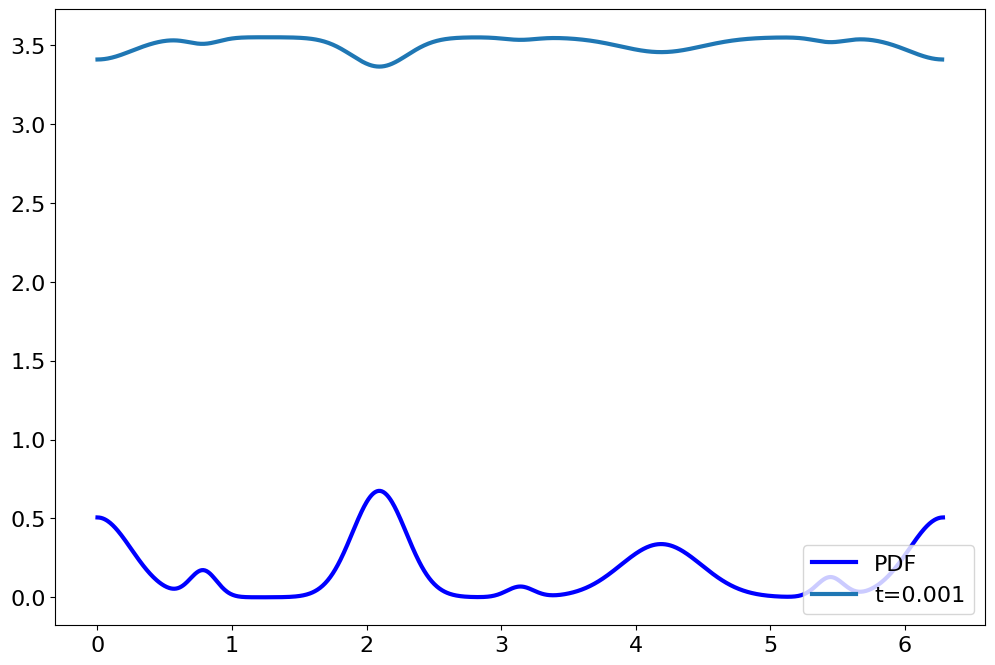

In [6]:
p = 2
ts = [.001]

dx = 2*np.pi/num_samp

plt.figure(figsize=(12, 8))

plt.plot(angles, pdf_values, label='PDF', color='blue',linewidth=3)

for t in ts:
    D = pairwise_diffusion_distances(angles,t)
    mode_frechet_mean_values = np.zeros(len(D))
        
    mode_frechet_mean_values = np.sum(D**p*pdf_values[:-1]*dx,axis = 1)**(1/p)
    plt.plot(angles[:-1],mode_frechet_mean_values,label=f't={t}',linewidth=3)
    
ax = plt.gca()

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
    
plt.legend(loc = 'lower right',fontsize=16)
plt.show()

### Deviation Function

We calculate the associated deviation function (with $p=2$) for the distribution above. The plot shows the distribution and the deviation function after "unwrapping" the circle.

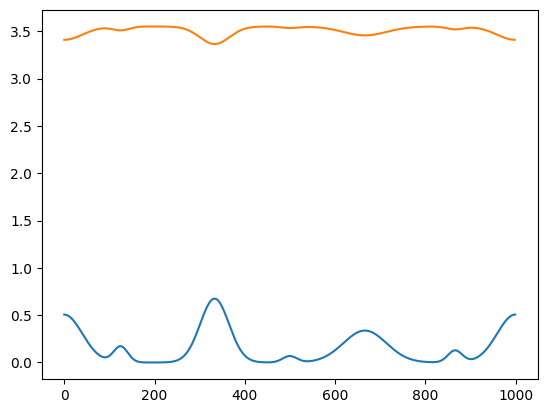

In [7]:
p = 2

deviation_values = mode_frechet_mean_values

plt.plot(pdf_values)
plt.plot(deviation_values)
plt.show()

### BMT

The following generates a picture of the associated BMT.

In [8]:
import matplotlib.colors as mcolors
import colorsys

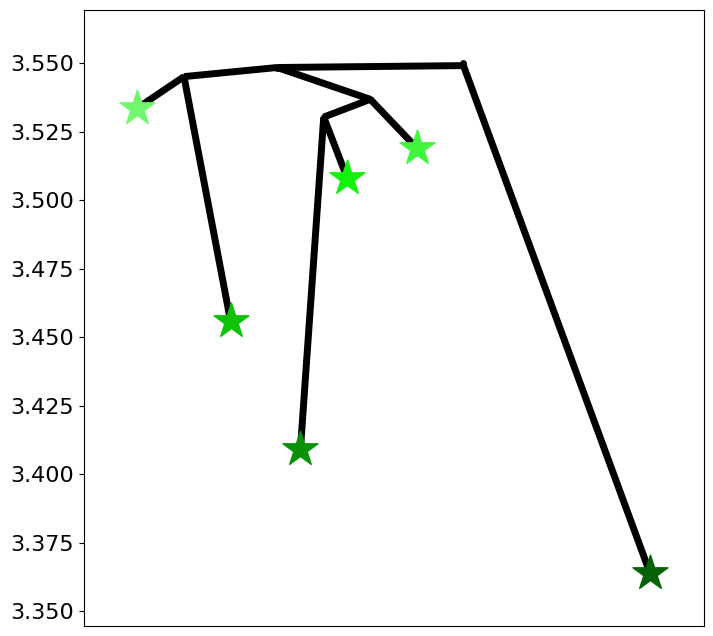

In [9]:
angles0 = angles[:-1]

G = nx.Graph()
G.add_nodes_from(list(range(len(angles0))))
G.add_edges_from([(i,i+1) for i in range(len(angles0)-1)])
G.add_edge(len(angles0)-1,0)

f = {i:deviation_values[i] for i in range(len(angles0))}

T = simplify_merge_tree(get_merge_tree(G,f))

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color = 'black', width = 5)

leaves = [node for node in T if nx.degree(T)[node] == 1]
leaves.pop();

# Define a fixed green hue (around 120 degrees -> 120/360 = 0.33 in HSL)
hue = 0.33         # green
saturation = 0.9   # strong green
lightness_vals = np.linspace(0.2,0.8,len(leaves)+1)  # from dark to light

# Generate list of green colors in increasing lightness
green_colors = [colorsys.hls_to_rgb(hue, l, saturation) for l in lightness_vals]

# Optionally convert RGB values to hex for use in matplotlib
green_colors_hex = [mcolors.to_hex(rgb) for rgb in green_colors]

for i,node in enumerate(leaves):
    
    x_min = np.array([pos[node][0]])
    y_min = np.array([pos[node][1]])
    plt.scatter(x_min, y_min, color=green_colors_hex[i], s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
# ax.set_ylim(1.5, 2.2)

plt.savefig('mode_merge_tree_circle_001.png', format='png', dpi=300)

Finally, we plot the distribution with the local minima of the Fréchet function indicated. Colors corrspond to the leaves on the BMT.

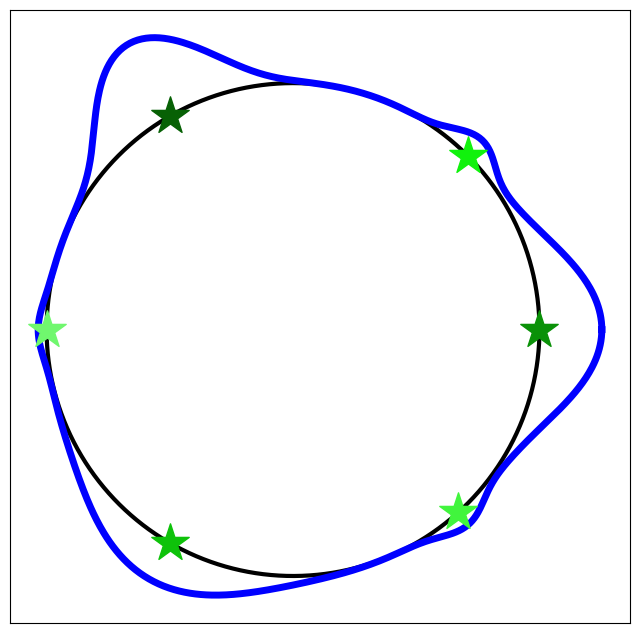

In [10]:
# Convert to Cartesian for plotting
x_circle = np.cos(angles)
y_circle = np.sin(angles)
x_pdf = (1 + pdf_values/2)*np.cos(angles)
y_pdf = (1 + pdf_values/2)*np.sin(angles)

# Plot
plt.figure(figsize=(8,8))
plt.plot(x_circle, y_circle, label="Circle outline", color = 'black', linewidth = 3)
plt.plot(x_pdf, y_pdf, label="4-modal PDF", color = 'blue', linewidth = 5)
plt.gca().set_aspect("equal", "box")
plt.xticks([])
plt.yticks([])

for i,node in enumerate(leaves):
    
    other_node_circle_value = get_key(f,T.nodes[node]['height'])[0]
    plt.scatter(x_circle[other_node_circle_value], y_circle[other_node_circle_value], color=green_colors_hex[i], s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)
    
plt.savefig('mode_circle_distribution_001.png', format='png', dpi=300)

plt.show()

### Fréchet variance for diffusion distances - $t=.01$

0.01 done


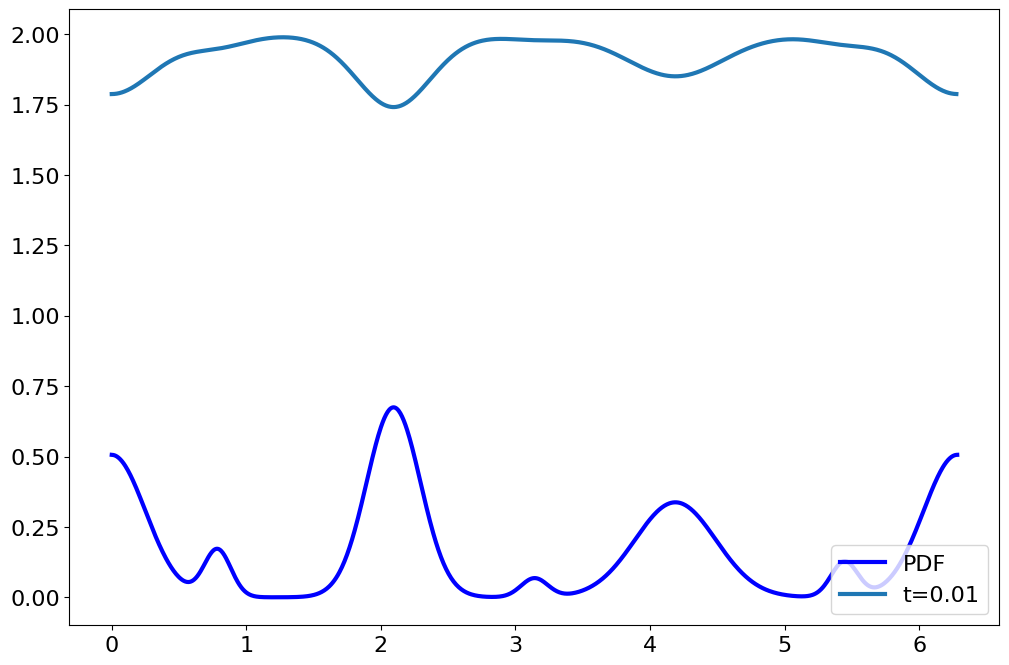

In [11]:
p = 2
ts = [.01]

dx = 2*np.pi/num_samp

plt.figure(figsize=(12, 8))

plt.plot(angles, pdf_values, label='PDF', color='blue',linewidth=3)

for t in ts:
    D = pairwise_diffusion_distances(angles,t)  
    mode_frechet_mean_values = np.sum(D**p*pdf_values[:-1]*dx,axis = 1)**(1/p)
    plt.plot(angles[:-1],mode_frechet_mean_values,label=f't={t}',linewidth=3)
    print(t, 'done')
    
ax = plt.gca()

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
    
plt.legend(loc = 'lower right',fontsize=16)
plt.show()

### Deviation Function

We calculate the associated deviation function (with $p=2$) for the distribution above. The plot shows the distribution and the deviation function after "unwrapping" the circle.

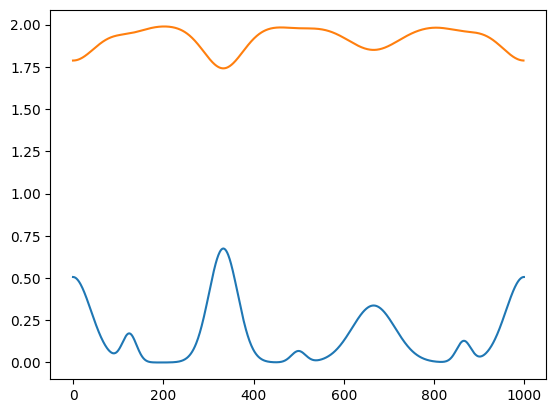

In [12]:
p = 2

deviation_values = mode_frechet_mean_values

plt.plot(pdf_values)
plt.plot(deviation_values)
plt.show()

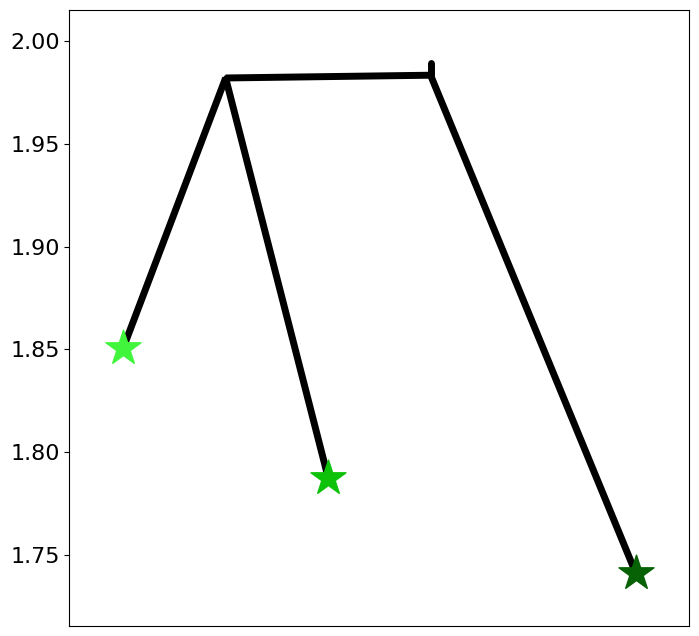

In [13]:
angles0 = angles[:-1]

G = nx.Graph()
G.add_nodes_from(list(range(len(angles0))))
G.add_edges_from([(i,i+1) for i in range(len(angles0)-1)])
G.add_edge(len(angles0)-1,0)

f = {i:deviation_values[i] for i in range(len(angles0))}

T = simplify_merge_tree(get_merge_tree(G,f))

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

leaves = [node for node in T if nx.degree(T)[node] == 1]
leaves.pop();

# Define a fixed green hue (around 120 degrees -> 120/360 = 0.33 in HSL)
hue = 0.33         # green
saturation = 0.9   # strong green
lightness_vals = np.linspace(0.2,0.8,len(leaves)+1)  # from dark to light

# Generate list of green colors in increasing lightness
green_colors = [colorsys.hls_to_rgb(hue, l, saturation) for l in lightness_vals]

# Optionally convert RGB values to hex for use in matplotlib
green_colors_hex = [mcolors.to_hex(rgb) for rgb in green_colors]

for i,node in enumerate(leaves):
    
    x_min = np.array([pos[node][0]])
    y_min = np.array([pos[node][1]])
    plt.scatter(x_min, y_min, color=green_colors_hex[i], s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
# ax.set_ylim(1.5, 2.2)

plt.savefig('mode_merge_tree_circle_01.png', format='png', dpi=300)

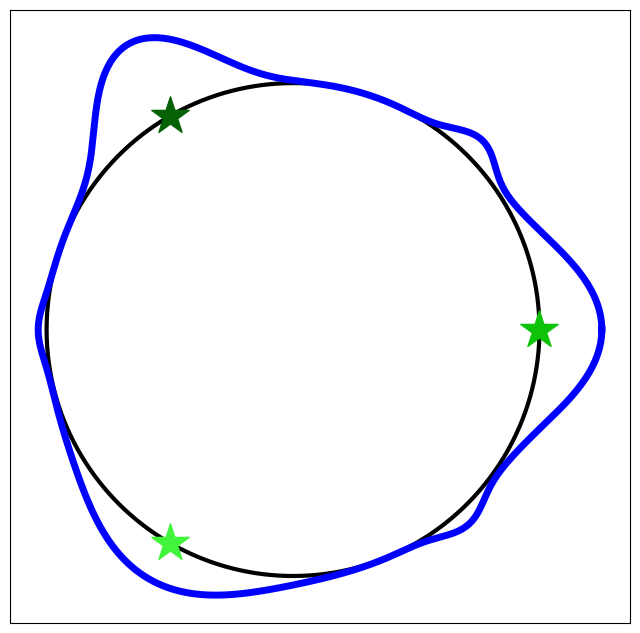

In [14]:
# Convert to Cartesian for plotting
x_circle = np.cos(angles)
y_circle = np.sin(angles)
x_pdf = (1 + pdf_values/2)*np.cos(angles)
y_pdf = (1 + pdf_values/2)*np.sin(angles)

# Plot
plt.figure(figsize=(8,8))
plt.plot(x_circle, y_circle, label="Circle outline", color = 'black', linewidth = 3)
plt.plot(x_pdf, y_pdf, label="4-modal PDF", color = 'blue', linewidth = 5)
plt.gca().set_aspect("equal", "box")
plt.xticks([])
plt.yticks([])

for i,node in enumerate(leaves):
    
    other_node_circle_value = get_key(f,T.nodes[node]['height'])[0]
    plt.scatter(x_circle[other_node_circle_value], y_circle[other_node_circle_value], color=green_colors_hex[i], s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)
    
plt.savefig('mode_tree_complicated_circle_distribution_01.png', format='png', dpi=300)

plt.show()

### Fréchet variance for diffusion distances - $t=.1$

0.2 done


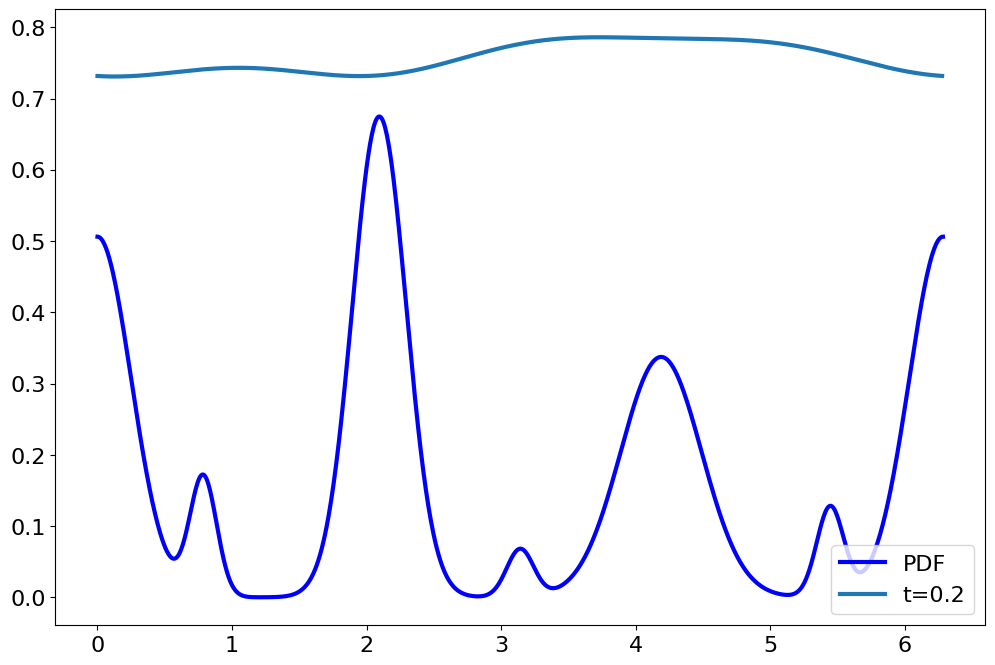

In [27]:
p = 2
ts = [0.2]

dx = 2*np.pi/num_samp

plt.figure(figsize=(12, 8))

plt.plot(angles, pdf_values, label='PDF', color='blue',linewidth=3)

for t in ts:
    D = pairwise_diffusion_distances(angles,t)
    mode_frechet_mean_values = np.sum(D**p*pdf_values[:-1]*dx,axis = 1)**(1/p)
    plt.plot(angles[:-1],mode_frechet_mean_values,label=f't={t}',linewidth=3)
    print(t, 'done')
    
ax = plt.gca()

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
    
plt.legend(loc = 'lower right',fontsize=16)
plt.show()

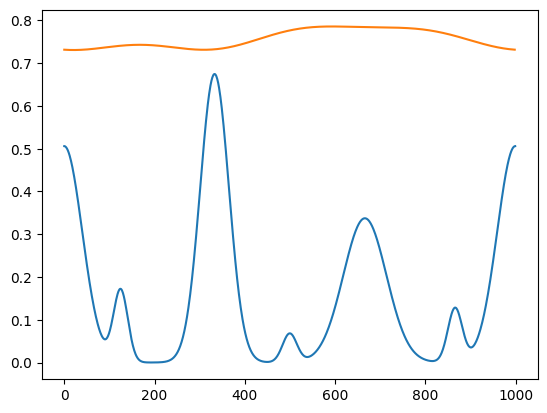

In [28]:
p = 2

deviation_values = mode_frechet_mean_values

plt.plot(pdf_values)
plt.plot(deviation_values)
plt.show()

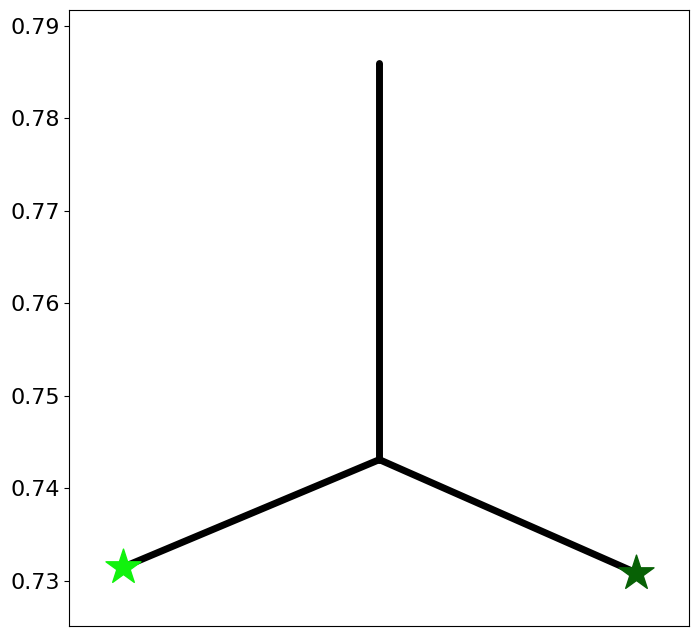

In [29]:
angles0 = angles[:-1]

G = nx.Graph()
G.add_nodes_from(list(range(len(angles0))))
G.add_edges_from([(i,i+1) for i in range(len(angles0)-1)])
G.add_edge(len(angles0)-1,0)

f = {i:deviation_values[i] for i in range(len(angles0))}

T = simplify_merge_tree(get_merge_tree(G,f))

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

leaves = [node for node in T if nx.degree(T)[node] == 1]
leaves.pop();

# Define a fixed green hue (around 120 degrees -> 120/360 = 0.33 in HSL)
hue = 0.33         # green
saturation = 0.9   # strong green
lightness_vals = np.linspace(0.2,0.8,len(leaves)+1)  # from dark to light

# Generate list of green colors in increasing lightness
green_colors = [colorsys.hls_to_rgb(hue, l, saturation) for l in lightness_vals]

# Optionally convert RGB values to hex for use in matplotlib
green_colors_hex = [mcolors.to_hex(rgb) for rgb in green_colors]

for i,node in enumerate(leaves):
    
    x_min = np.array([pos[node][0]])
    y_min = np.array([pos[node][1]])
    plt.scatter(x_min, y_min, color=green_colors_hex[i], s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
# ax.set_ylim(1.5, 2.2)

plt.savefig('mode_merge_tree_circle_1.png', format='png', dpi=300)

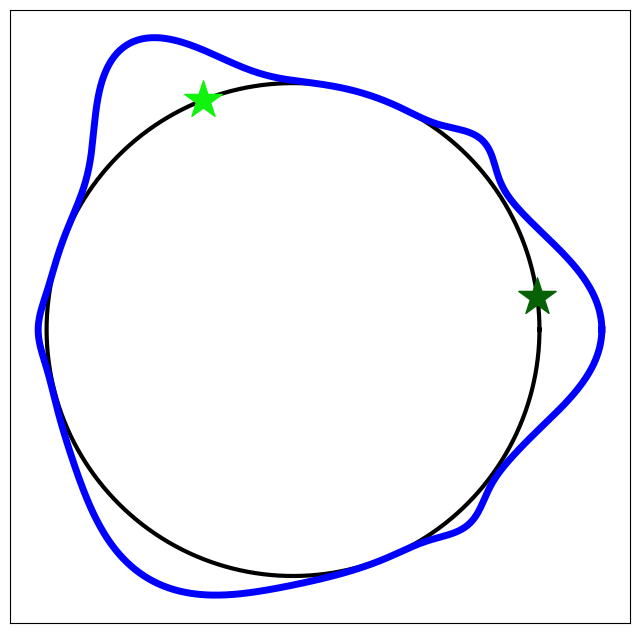

In [30]:
# Convert to Cartesian for plotting
x_circle = np.cos(angles)
y_circle = np.sin(angles)
x_pdf = (1 + pdf_values/2)*np.cos(angles)
y_pdf = (1 + pdf_values/2)*np.sin(angles)

# Plot
plt.figure(figsize=(8,8))
plt.plot(x_circle, y_circle, label="Circle outline", color = 'black', linewidth = 3)
plt.plot(x_pdf, y_pdf, label="4-modal PDF", color = 'blue', linewidth = 5)
plt.gca().set_aspect("equal", "box")
plt.xticks([])
plt.yticks([])

for i,node in enumerate(leaves):
    
    other_node_circle_value = get_key(f,T.nodes[node]['height'])[0]
    plt.scatter(x_circle[other_node_circle_value], y_circle[other_node_circle_value], color=green_colors_hex[i], s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)
    
plt.savefig('mode_tree_complicated_circle_distribution_1.png', format='png', dpi=300)

plt.show()